In [1]:
from dolfinx import mesh, fem, plot, geometry
import dolfinx.fem.petsc
import dolfinx.nls.petsc
from mpi4py import MPI
import ufl
from petsc4py import PETSc
from ufl import dx, grad, dot, jump, avg
from ufl import dx, grad, dot, jump, avg
import numpy as np
import matplotlib.pyplot as plt
import pyvista


msh = mesh.create_unit_square(MPI.COMM_WORLD, 100, 100)
V = fem.FunctionSpace(msh, ("DG", 1))
uD = fem.Function(V)
uD.interpolate(lambda x: np.full(x[0].shape, 0.0))

# create mesh tags
def marker_interface_1(x):
    return np.isclose(x[0], 0.5)

def marker_interface_2(x):
    return np.logical_and([x[0]>0.5], [np.isclose(x[1], 0.5)])


tdim = msh.topology.dim
fdim = tdim - 1
msh.topology.create_connectivity(fdim, tdim)
facet_imap = msh.topology.index_map(tdim - 1)
boundary_facets = mesh.exterior_facet_indices(msh.topology)
interface_facets_1 = mesh.locate_entities(msh, tdim - 1, marker_interface_1)
interface_facets_2 = mesh.locate_entities(msh, tdim - 1, marker_interface_2)
num_facets = facet_imap.size_local + facet_imap.num_ghosts
indices = np.arange(0, num_facets)
# values = np.arange(0, num_facets, dtype=np.intc)
values = np.zeros(indices.shape, dtype=np.intc)  # all facets are tagged with zero

values[boundary_facets] = 1
values[interface_facets_1] = 2
values[interface_facets_2] = 3

mesh_tags_facets = mesh.meshtags(msh, tdim - 1, indices, values) 

ds = ufl.Measure("ds", domain=msh, subdomain_data=mesh_tags_facets)
dS = ufl.Measure("dS", domain=msh, subdomain_data=mesh_tags_facets)
u = fem.Function(V)
u_n = fem.Function(V)
v = ufl.TestFunction(V)

h = ufl.CellDiameter(msh)
n = ufl.FacetNormal(msh)

# Define parameters
alpha = 1000

# Simulation constants
f = fem.Constant(msh, PETSc.ScalarType(2.0))
K1 = fem.Constant(msh, PETSc.ScalarType(2.0))
K2 = fem.Constant(msh, PETSc.ScalarType(4.0))

# Define variational problem
F = 0
F += dot(grad(v), grad(u))*dx - dot(v*n, grad(u))*ds \
   - dot(avg(grad(v)), jump(u, n))*dS(0) - dot(jump(v, n), avg(grad(u)))*dS(0) \
   + alpha/avg(h)*dot(jump(v, n), jump(u, n))*dS(0) + alpha/h*v*u*ds

# source
F += -v*f*dx 

# Dirichlet BC
F += - dot(grad(v), u*n)*ds \
   + uD*dot(grad(v), n)*ds - alpha/h*uD*v*ds

# Interface BC #1
F += - dot(avg(grad(v)), n('-'))*(u('-')*(K1/K2-1))*dS(2)
F += alpha/avg(h)*dot(jump(v,n),n('-'))*(u('-')*(K1/K2-1))*dS(2)

# Interface BC #2
F += - dot(avg(grad(v)), n('-'))*(u('-')*(K2/K1-1))*dS(3)
F += alpha/avg(h)*dot(jump(v,n),n('-'))*(u('-')*(K2/K1-1))*dS(3)

# symmetry
F += - dot(avg(grad(v)), jump(u, n))*dS(2)
F += - dot(avg(grad(v)), jump(u, n))*dS(3)

# coercivity
F += + alpha/avg(h)*dot(jump(v, n), jump(u, n))*dS(2)
F += + alpha/avg(h)*dot(jump(v, n), jump(u, n))*dS(3)


problem = dolfinx.fem.petsc.NonlinearProblem(F, u)
solver = dolfinx.nls.petsc.NewtonSolver(MPI.COMM_WORLD, problem)
solver.solve(u)

(1, True)

Text(0.5, 1.0, 'y = 0.8')

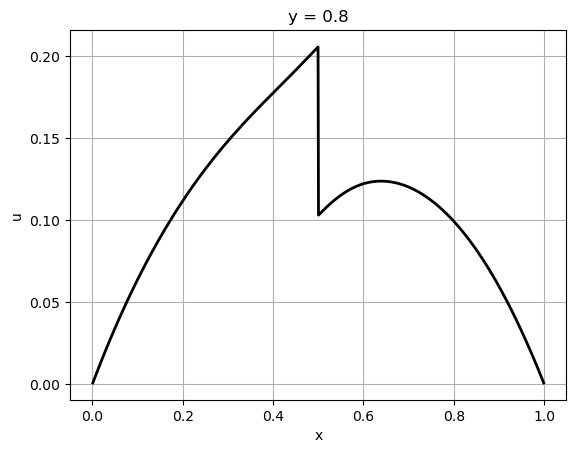

In [9]:
# Plot at y = 0.4 - Upper domain

bb_tree = geometry.bb_tree(msh, msh.topology.dim)
n_points = 1000
tol = 0.001  # Avoid hitting the outside of the domain
x = np.linspace(0 + tol, 1 - tol, n_points)
y = np.ones(n_points)*0.4
points = np.zeros((3, n_points))
points[0] = x
points[1] = y
u_values = []
cells = []
points_on_proc = []
# Find cells whose bounding-box collide with the the points
cell_candidates = geometry.compute_collisions_points(bb_tree, points.T)
# Choose one of the cells that contains the point
colliding_cells = geometry.compute_colliding_cells(msh, cell_candidates, points.T)
for i, point in enumerate(points.T):
    if len(colliding_cells.links(i)) > 0:
        points_on_proc.append(point)
        cells.append(colliding_cells.links(i)[0])
points_on_proc = np.array(points_on_proc, dtype=np.float64)
u_values = u.eval(points_on_proc, cells)
fig = plt.figure()
plt.plot(points_on_proc[:, 0], u_values, "k", linewidth=2)
plt.grid(True)
plt.xlabel('x')
plt.ylabel('u')
plt.title('y = 0.8')
# plt.savefig('lineplot.jpg')


Text(0.5, 1.0, 'y = 0.4')

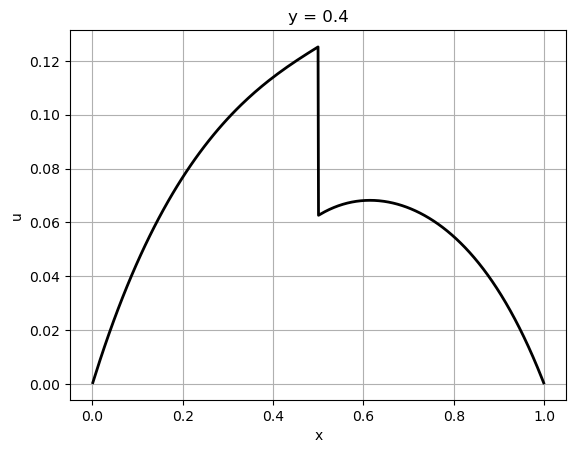

In [8]:
# Plot at y = 0.8 - Upper domain

bb_tree = geometry.bb_tree(msh, msh.topology.dim)
n_points = 1000
tol = 0.001  # Avoid hitting the outside of the domain
x = np.linspace(0 + tol, 1 - tol, n_points)
y = np.ones(n_points)*0.8
points = np.zeros((3, n_points))
points[0] = x
points[1] = y
u_values = []
cells = []
points_on_proc = []
# Find cells whose bounding-box collide with the the points
cell_candidates = geometry.compute_collisions_points(bb_tree, points.T)
# Choose one of the cells that contains the point
colliding_cells = geometry.compute_colliding_cells(msh, cell_candidates, points.T)
for i, point in enumerate(points.T):
    if len(colliding_cells.links(i)) > 0:
        points_on_proc.append(point)
        cells.append(colliding_cells.links(i)[0])
points_on_proc = np.array(points_on_proc, dtype=np.float64)
u_values = u.eval(points_on_proc, cells)
fig = plt.figure()
plt.plot(points_on_proc[:, 0], u_values, "k", linewidth=2)
plt.grid(True)
plt.xlabel('x')
plt.ylabel('u')
plt.title('y = 0.4')
# plt.savefig('lineplot.jpg')

Text(0.5, 1.0, 'x = 0.8')

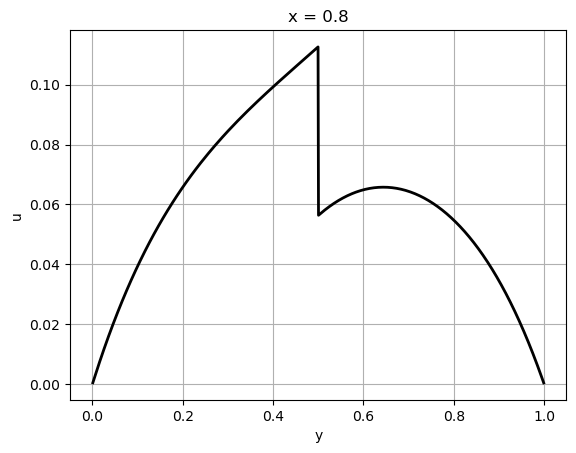

In [10]:
bb_tree = geometry.bb_tree(msh, msh.topology.dim)
n_points = 1000
tol = 0.001  # Avoid hitting the outside of the domain
x = np.ones(n_points)*0.8
y = np.linspace(0 + tol, 1 - tol, n_points)
points = np.zeros((3, n_points))
points[0] = x
points[1] = y
u_values = []
cells = []
points_on_proc = []
# Find cells whose bounding-box collide with the the points
cell_candidates = geometry.compute_collisions_points(bb_tree, points.T)
# Choose one of the cells that contains the point
colliding_cells = geometry.compute_colliding_cells(msh, cell_candidates, points.T)
for i, point in enumerate(points.T):
    if len(colliding_cells.links(i)) > 0:
        points_on_proc.append(point)
        cells.append(colliding_cells.links(i)[0])
points_on_proc = np.array(points_on_proc, dtype=np.float64)
u_values = u.eval(points_on_proc, cells)
fig = plt.figure()
plt.plot(points_on_proc[:,1], u_values, "k", linewidth=2)
plt.grid(True)
plt.xlabel('y')
plt.ylabel('u')
plt.title('x = 0.8')
# plt.savefig('lineplot.jpg')

In [3]:
u_jump = u_values[int(n_points/2)] - u_values[int(n_points/2)-1]
u_ratio = u_values[int(n_points/2)] / u_values[int(n_points/2)-1]
print(f'Jump on the interface {u_ratio}')

Jump on the interface [0.49118079]



No module named 'trame.ui.vuetify'

Falling back to a static output.
  warnings.warn(

2023-11-01 10:33:14.463 ( 331.121s) [        68E0A740]   vtkShaderProgram.cxx:452    ERR| vtkShaderProgram (0x561848be7730): 1: #version 140
2: #ifdef GL_ES
3: #ifdef GL_FRAGMENT_PRECISION_HIGH
4: precision highp float;
5: precision highp sampler2D;
6: precision highp sampler3D;
7: #else
8: precision mediump float;
9: precision mediump sampler2D;
10: precision mediump sampler3D;
11: #endif
12: #define texelFetchBuffer texelFetch
13: #define texture1D texture
14: #define texture2D texture
15: #define texture3D texture
16: #else // GL_ES
17: #define highp
18: #define mediump
19: #define lowp
20: #if __VERSION__ == 150
21: #define texelFetchBuffer texelFetch
22: #define texture1D texture
23: #define texture2D texture
24: #define texture3D texture
25: #endif
26: #endif // GL_ES
27: #define varying in
28: 
29: 
30: /*=========================================================================
31: 
32:   Pro

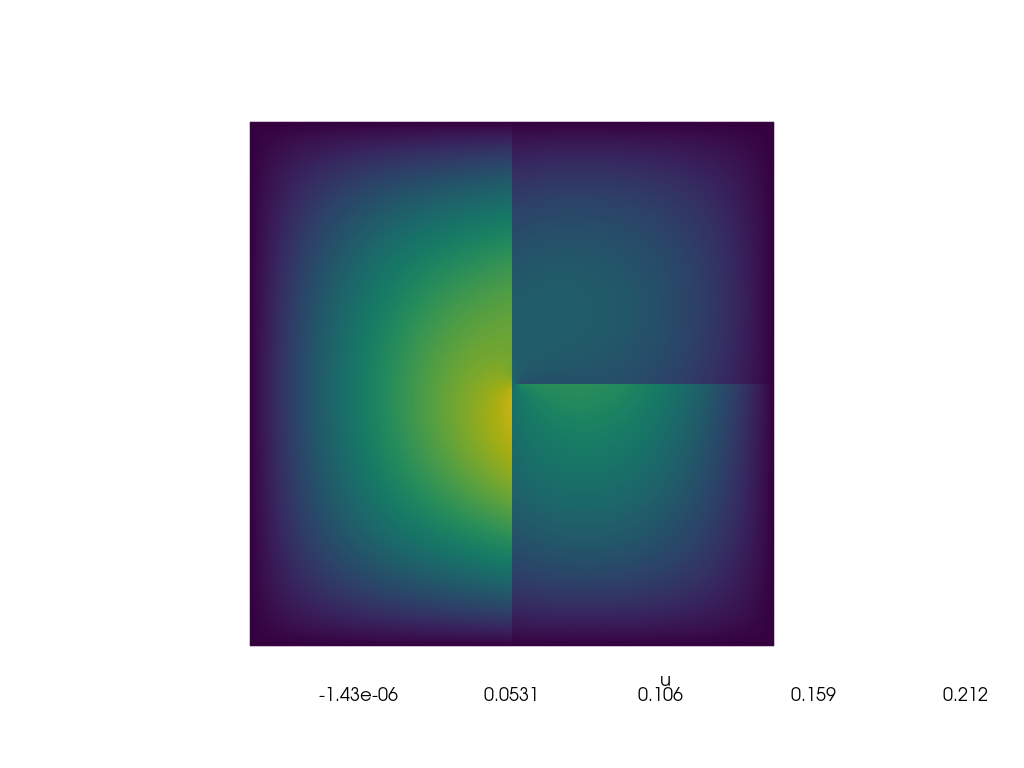

In [6]:
pyvista.OFF_SCREEN = False

pyvista.start_xvfb()

u_topology, u_cell_types, u_geometry = plot.vtk_mesh(V)
u_grid = pyvista.UnstructuredGrid(u_topology, u_cell_types, u_geometry)
u_grid.point_data["u"] = u.x.array.real
u_grid.set_active_scalars("u")
u_plotter = pyvista.Plotter()
u_plotter.add_mesh(u_grid, show_edges=False)
u_plotter.view_xy()
if not pyvista.OFF_SCREEN:
    u_plotter.show()
else:
    figure = u_plotter.screenshot("DG_multiInterfaces.png")